In [5]:
import networkx as nx
import random
import math
import matplotlib.pyplot as plt
from copy import deepcopy
from collections import deque
import time
import statistics

GRAPH_NODE_COUNT = 30
CONNECTIVITY_P = 0.1
CAPACITY_MIN = 1
CAPACITY_MAX = 10
SOURCE_NODE = 0
SINK_NODE = GRAPH_NODE_COUNT - 1
plt.rcParams.update({'figure.max_open_warning': 20})

def build_figure1A():
    G = nx.DiGraph()
    edges = [
        ("S","V",10,5), ("S","W",8,3), ("S","U",11,4),
        ("V","W",9,3), ("V","E",3,2),
        ("U","W",8,2), ("U","Z",12,2),
        ("W","E",8,1), ("W","Z",9,7),
        ("Z","E",9,9)
    ]
    for u,v,c,f in edges:
        G.add_edge(u, v, capacity=int(c), flow=int(f))
    return G

def flow_into_sink(G, sink):
    return sum(G[u][sink]['flow'] for u in G.predecessors(sink) if G.has_edge(u, sink))

def paths_from_E_to_S(G, E="E", S="S", cutoff=9):
    try:
        paths = list(nx.all_simple_paths(G, source=E, target=S, cutoff=cutoff))
    except nx.NetworkXNoPath:
        paths = []
    if paths:
        return paths
    try:
        paths_SE = list(nx.all_simple_paths(G, source=S, target=E, cutoff=cutoff))
    except nx.NetworkXNoPath:
        paths_SE = []
    if not paths_SE:
        return []
    paths_reversed = [list(reversed(p)) for p in paths_SE]
    return paths_reversed

def set_path_to_f_inplace(G, path_nodes, f):
    prev = []
    for u,v in zip(path_nodes[:-1], path_nodes[1:]):
        if G.has_edge(u,v):
            prev.append((u,v,G[u][v]['flow']))
            G[u][v]['flow'] = f
        elif G.has_edge(v,u):
            prev.append((v,u,G[v][u]['flow']))
            G[v][u]['flow'] = f
        else:
            continue
    return prev

def rollback_path_inplace(G, prev_edges):
    for (u,v,flow_old) in prev_edges:
        G[u][v]['flow'] = flow_old

def backward_conservation_repair(G, SOURCE="S", SINK="E"):
    order = []
    visited = {SINK}
    frontier = [SINK]
    while frontier:
        next_frontier = []
        for v in frontier:
            for u in G.predecessors(v):
                if u not in visited:
                    visited.add(u)
                    next_frontier.append(u)
        order.extend(next_frontier)
        frontier = next_frontier
    order = [n for n in order if n not in (SOURCE, SINK)]
    for n in order:
        inflow = sum(G[a][n]['flow'] for a in G.predecessors(n))
        outflow = sum(G[n][b]['flow'] for b in G.successors(n))
        if outflow > inflow:
            outs = sorted([(n,b) for b in G.successors(n)], key=lambda e: G[e[0]][e[1]]['flow'], reverse=True)
            need = outflow - inflow
            for u,v in outs:
                if need <= 0: break
                cur = G[u][v]['flow']
                reduce_amt = min(cur, need)
                G[u][v]['flow'] -= reduce_amt
                need -= reduce_amt
        elif inflow > outflow:
            outs = sorted([(n,b) for b in G.successors(n)], key=lambda e: (G[e[0]][e[1]]['capacity'] - G[e[0]][e[1]]['flow']), reverse=True)
            need = inflow - outflow
            for u,v in outs:
                if need <= 0: break
                avail = G[u][v]['capacity'] - G[u][v]['flow']
                add_amt = min(avail, need)
                G[u][v]['flow'] += add_amt
                need -= add_amt
    return True

def simulated_annealing_R1_exact(G_init, SOURCE="S", SINK="E", T_init=100.0, alpha=0.01, cutoff=9, seed=123, max_iters=10000):
    random.seed(seed)
    G = G_init
    paths = paths_from_E_to_S(G, E=SINK, S=SOURCE, cutoff=cutoff)
    if not paths:
        raise RuntimeError("No E->S or reversed paths found.")
    T = T_init
    current_flow = flow_into_sink(G, SINK)
    history = []
    for it in range(1, max_iters+1):
        if T <= 1e-9:
            break
        p = random.choice(paths)
        caps = []
        for u,v in zip(p[:-1], p[1:]):
            if G.has_edge(u,v):
                caps.append(G[u][v]['capacity'])
            elif G.has_edge(v,u):
                caps.append(G[v][u]['capacity'])
        if not caps:
            T *= (1 - alpha)
            continue
        m = min(caps)
        f = max(0, random.randint(1, m))
        prev_edges = set_path_to_f_inplace(G, p, f)
        new_flow = flow_into_sink(G, SINK)
        deltaE = new_flow - current_flow
        accept = False
        if deltaE >= 0:
            accept = True
        else:
            prob = math.exp(deltaE / T)
            if random.random() < prob:
                accept = True
        if accept:
            backward_conservation_repair(G, SOURCE, SINK)
            current_flow = flow_into_sink(G, SINK)
            history.append((it, True, p, f, deltaE, current_flow))
        else:
            rollback_path_inplace(G, prev_edges)
            history.append((it, False, p, f, deltaE, current_flow))
        T *= (1 - alpha)
    return G, current_flow, history

def plot_graph_named(G, pos, title):
    plt.figure(figsize=(7,3.5))
    nx.draw(G, pos, with_labels=True, node_size=900)
    edge_labels = {(u,v): f"{d['flow']}/{d['capacity']}" for u,v,d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    plt.title(title)
    plt.axis('off')
    plt.show()

def build_random_graph(num_nodes=GRAPH_NODE_COUNT, p=CONNECTIVITY_P, cap_min=CAPACITY_MIN, cap_max=CAPACITY_MAX, seed=None):
    if seed is not None:
        random.seed(seed)
    G = nx.gnp_random_graph(num_nodes, p, directed=True, seed=seed)
    attempts = 0
    while (not nx.has_path(G, SOURCE_NODE, num_nodes-1) or not nx.is_weakly_connected(G)) and attempts < 50:
        G = nx.gnp_random_graph(num_nodes, p, directed=True, seed=random.randint(0,10**9))
        attempts += 1
    for u,v in list(G.edges()):
        G[u][v]['capacity'] = random.randint(cap_min, cap_max)
        G[u][v]['flow'] = 0
    return G

def sample_simple_paths(G, source, sink, cutoff=10, max_paths=1000):
    paths = []
    try:
        gen = nx.all_simple_paths(G, source=source, target=sink, cutoff=cutoff)
        for p in gen:
            paths.append(p)
            if len(paths) >= max_paths:
                break
    except nx.NetworkXNoPath:
        pass
    if not paths:
        for _ in range(max_paths):
            cur = source; visited={cur}; path=[cur]
            for _ in range(cutoff):
                succ = [v for v in G.successors(cur) if v not in visited]
                if not succ: break
                cur = random.choice(succ); visited.add(cur); path.append(cur)
                if cur == sink: break
            if path[-1] == sink:
                paths.append(path)
    edge_paths = []
    for p in paths:
        edge_paths.append([(p[i], p[i+1]) for i in range(len(p)-1)])
    return edge_paths

def apply_delta_inplace(G, edge_list, delta, op):
    prev = []
    if op == "add":
        for (u,v) in edge_list:
            prev.append(G[u][v]['flow'])
            G[u][v]['flow'] += delta
    else:
        for (u,v) in edge_list:
            prev.append(G[u][v]['flow'])
            G[u][v]['flow'] -= delta
    return prev

def rollback_inplace(G, edge_list, prev):
    for (u,v), f in zip(edge_list, prev):
        G[u][v]['flow'] = f

def quick_feasible_edges(G, edge_list):
    for (u,v) in edge_list:
        f = G[u][v]['flow']; c = G[u][v]['capacity']
        if f < 0 or f > c:
            return False
    return True

def local_conservation_holds(G, nodes):
    for n in nodes:
        inflow = sum(G[a][n]['flow'] for a in G.predecessors(n) if G.has_edge(a,n))
        outflow = sum(G[n][b]['flow'] for b in G.successors(n) if G.has_edge(n,b))
        if inflow != outflow:
            return False
    return True

def local_repair_on_nodes(G, nodes, max_attempts=8):
    for _ in range(max_attempts):
        violated = []
        for n in nodes:
            if n == SOURCE_NODE or n == SINK_NODE: continue
            inflow = sum(G[a][n]['flow'] for a in G.predecessors(n) if G.has_edge(a,n))
            outflow = sum(G[n][b]['flow'] for b in G.successors(n) if G.has_edge(n,b))
            diff = inflow - outflow
            if diff != 0:
                violated.append((n,diff))
        if not violated: return True
        progressed = False
        for n,diff in violated:
            if diff > 0:
                outs = [(n,v) for v in G.successors(n) if G.has_edge(n,v)]
                outs_sorted = sorted(outs, key=lambda e: (G[e[0]][e[1]]['capacity'] - G[e[0]][e[1]]['flow']), reverse=True)
                need = diff
                for u,v in outs_sorted:
                    avail = G[u][v]['capacity'] - G[u][v]['flow']
                    if avail <= 0: continue
                    transfer = min(avail, need)
                    G[u][v]['flow'] += transfer
                    need -= transfer
                    progressed = True
                    if need == 0: break
            else:
                outs = [(n,v) for v in G.successors(n) if G.has_edge(n,v)]
                outs_sorted = sorted(outs, key=lambda e: G[e[0]][e[1]]['flow'], reverse=True)
                rem = -diff
                for u,v in outs_sorted:
                    cur = G[u][v]['flow']
                    if cur <= 0: continue
                    reduce_amt = min(cur, rem)
                    G[u][v]['flow'] -= reduce_amt
                    rem -= reduce_amt
                    progressed = True
                    if rem == 0: break
        if not progressed: break
    return local_conservation_holds(G, nodes)

def generate_successor_fast(G, edge_path_cache, add_prob=0.7, max_tries=40):
    tries = 0
    while tries < max_tries:
        tries += 1
        edge_path = random.choice(edge_path_cache)
        try:
            m_add = min(G[u][v]['capacity'] - G[u][v]['flow'] for (u,v) in edge_path)
            m_sub = min(G[u][v]['flow'] for (u,v) in edge_path)
        except Exception:
            continue
        if m_add == 0 and m_sub == 0:
            continue
        if m_add > 0 and random.random() < add_prob:
            delta = random.randint(1, m_add); op = "add"
        else:
            if m_sub == 0: continue
            delta = random.randint(1, m_sub); op = "sub"
        prev = apply_delta_inplace(G, edge_path, delta, op)
        if not quick_feasible_edges(G, edge_path):
            rollback_inplace(G, edge_path, prev); continue
        nodes_to_check = set([u for u,v in edge_path] + [v for u,v in edge_path])
        nodes_to_check.discard(SOURCE_NODE); nodes_to_check.discard(SINK_NODE)
        if local_conservation_holds(G, nodes_to_check):
            return edge_path, delta, op, prev, nodes_to_check
        repaired_ok = local_repair_on_nodes(G, nodes_to_check, max_attempts=8)
        if repaired_ok:
            return edge_path, delta, op, prev, nodes_to_check
        rollback_inplace(G, edge_path, prev)
    return None, None, None, None, None

def heuristic_score_sample(G, sink, lambda_cons=50, lambda_cap=1000):
    total_flow = flow_into_sink(G, sink)
    cons = 0
    for n in G.nodes():
        if n == SOURCE_NODE or n == SINK_NODE: continue
        inflow = sum(G[a][n]['flow'] for a in G.predecessors(n) if G.has_edge(a,n))
        outflow = sum(G[n][b]['flow'] for b in G.successors(n) if G.has_edge(n,b))
        cons += abs(inflow - outflow)
    capv = 0
    for u,v,d in G.edges(data=True):
        f = d['flow']; c = d['capacity']
        if f > c: capv += (f-c)
        if f < 0: capv += -f
    score = total_flow - lambda_cons*cons - lambda_cap*capv
    return score, total_flow, cons, capv

def greedy_init_flow(G, source, sink, max_iters=1000):
    for _ in range(max_iters):
        parent = {}
        q = deque([source])
        found = False
        visited = {source}
        while q and not found:
            u = q.popleft()
            for v in G.successors(u):
                if v in visited: continue
                residual = G[u][v]['capacity'] - G[u][v]['flow']
                if residual <= 0: continue
                parent[v] = u
                if v == sink:
                    found = True; break
                visited.add(v); q.append(v)
        if not found:
            break
        path_edges = []
        cur = sink
        while cur != source:
            prev = parent[cur]
            path_edges.append((prev,cur))
            cur = prev
        path_edges.reverse()
        m_add = min(G[u][v]['capacity'] - G[u][v]['flow'] for u,v in path_edges)
        for u,v in path_edges:
            G[u][v]['flow'] += m_add
    return G

def simulated_annealing_fast(G_init, source, sink, T_init=200.0, alpha=0.03, max_iters_per_T=200,
                             path_cache=None, path_cutoff=10, max_path_cache=1000, seed=42,
                             use_greedy_init=False):
    random.seed(seed)
    G = G_init
    if use_greedy_init:
        greedy_init_flow(G, source, sink, max_iters=200)
    if path_cache is None:
        path_cache = sample_simple_paths(G, source, sink, cutoff=path_cutoff, max_paths=max_path_cache)
    if not path_cache:
        raise RuntimeError("No cached paths for SA.")
    score_cur, flow_cur, _, _ = heuristic_score_sample(G, sink)
    best_score = score_cur; best_flow = flow_cur
    best_snapshot = None
    T = T_init
    history = []
    while T > 1e-6:
        for _ in range(max_iters_per_T):
            res = generate_successor_fast(G, path_cache)
            if res[0] is None:
                continue
            edge_path, delta, op, prev, nodes_checked = res
            score_cand, flow_cand, cons_c, cap_c = heuristic_score_sample(G, sink)
            dscore = score_cand - score_cur
            accept = False
            if dscore >= 0:
                accept = True
            else:
                prob = math.exp(dscore / T) if T > 0 else 0.0
                if random.random() < prob:
                    accept = True
            if accept:
                score_cur = score_cand; flow_cur = flow_cand
                if score_cur > best_score:
                    best_score = score_cur; best_flow = flow_cur
                    best_snapshot = { (u,v): G[u][v]['flow'] for u,v in G.edges() }
                history.append((T, True, flow_cur))
            else:
                rollback_inplace(G, edge_path, prev)
                history.append((T, False, flow_cur))
        T = T * (1 - alpha)
    G_result = G.copy()
    if best_snapshot is not None:
        for (u,v), f in best_snapshot.items():
            G_result[u][v]['flow'] = f
    else:
        for u,v,d in G_result.edges(data=True):
            d['flow'] = G[u][v]['flow']
    return G_result, best_score, history

# solution validator
def validate_solution(G, source=SOURCE_NODE, sink=SINK_NODE, verbose=True):
    ok = True
    for u,v,d in G.edges(data=True):
        f = d.get('flow', 0)
        c = d.get('capacity', 0)
        if f < 0 or f > c:
            ok = False
            if verbose:
                print(f"Capacity violation on edge {u}->{v}: flow={f}, cap={c}")
    for n in G.nodes():
        if n == source or n == sink:
            continue
        inflow = sum(G[a][n]['flow'] for a in G.predecessors(n) if G.has_edge(a,n))
        outflow = sum(G[n][b]['flow'] for b in G.successors(n) if G.has_edge(n,b))
        if inflow != outflow:
            ok = False
            if verbose:
                print(f"Conservation violation at node {n}: inflow={inflow}, outflow={outflow}")
    if verbose:
        if ok:
            print("Validation: PASS (capacities and conservation satisfied).")
        else:
            print("Validation: FAIL (see messages above).")
    return ok

**R1**

Initial total flow into E (Figure1A): 12


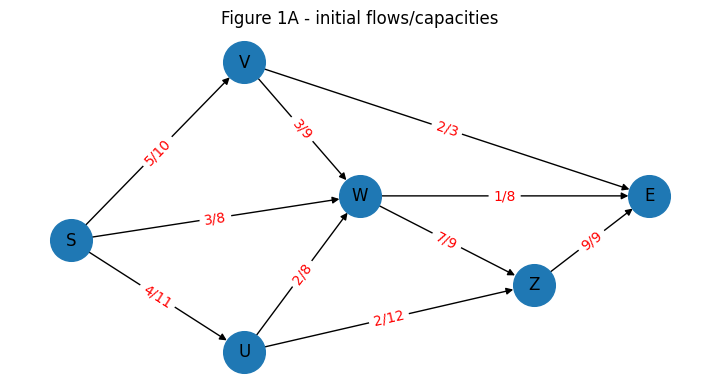

Final total flow into E (R1 SA): 20


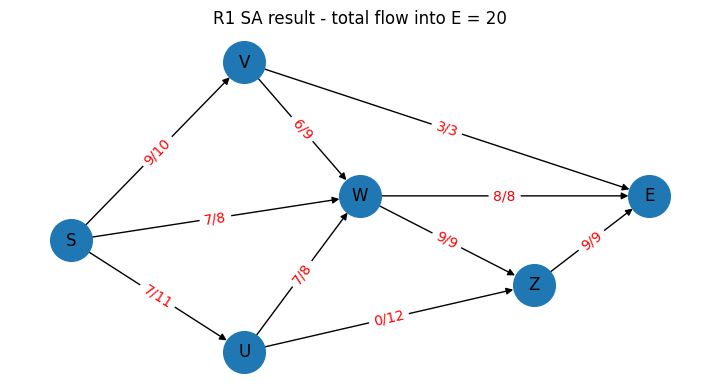

R1 Trace (first 10 entries):
iter=1, accepted=True, path=['E', 'Z', 'W', 'V', 'S'], f=1, ΔE=-8, flow_into_E=8
iter=2, accepted=True, path=['E', 'W', 'S'], f=4, ΔE=3, flow_into_E=9
iter=3, accepted=True, path=['E', 'V', 'S'], f=3, ΔE=3, flow_into_E=11
iter=4, accepted=True, path=['E', 'Z', 'W', 'V', 'S'], f=9, ΔE=4, flow_into_E=15
iter=5, accepted=True, path=['E', 'Z', 'W', 'V', 'S'], f=7, ΔE=-2, flow_into_E=15
iter=6, accepted=True, path=['E', 'Z', 'W', 'V', 'S'], f=4, ΔE=-5, flow_into_E=12
iter=7, accepted=True, path=['E', 'W', 'V', 'S'], f=4, ΔE=0, flow_into_E=12
iter=8, accepted=True, path=['E', 'Z', 'W', 'U', 'S'], f=4, ΔE=-2, flow_into_E=14
iter=9, accepted=True, path=['E', 'Z', 'W', 'S'], f=1, ΔE=-7, flow_into_E=9
iter=10, accepted=True, path=['E', 'V', 'S'], f=3, ΔE=1, flow_into_E=8


In [6]:
G_r1 = build_figure1A()
pos_named = {"S":(-1,0),"V":(-0.4,0.8),"W":(0.0,0.2),"U":(-0.4,-0.5),"Z":(0.6,-0.2),"E":(1.0,0.2)}
print("Initial total flow into E (Figure1A):", flow_into_sink(G_r1, "E"))
plot_graph_named(G_r1, pos_named, "Figure 1A - initial flows/capacities")
G_r1_res, tf_r1, hist_r1 = simulated_annealing_R1_exact(G_r1, SOURCE="S", SINK="E", T_init=100.0, alpha=0.01, cutoff=9, seed=42, max_iters=2000)
print("Final total flow into E (R1 SA):", tf_r1)
plot_graph_named(G_r1_res, pos_named, f"R1 SA result - total flow into E = {tf_r1}")
print("R1 Trace (first 10 entries):")
for h in hist_r1[:10]:
    print(f"iter={h[0]}, accepted={h[1]}, path={h[2]}, f={h[3]}, ΔE={h[4]}, flow_into_E={h[5]}")

**R2**

Random graph: nodes=30, edges=98
SA finished in 45.82s — tf (SA) = 14
Edmonds-Karp finished in 0.00s — tf_net (optimal) = 14

Validating SA solution (R2)...
Validation: PASS (capacities and conservation satisfied).
Validating Edmonds-Karp solution (R2)...
Validation: PASS (capacities and conservation satisfied).


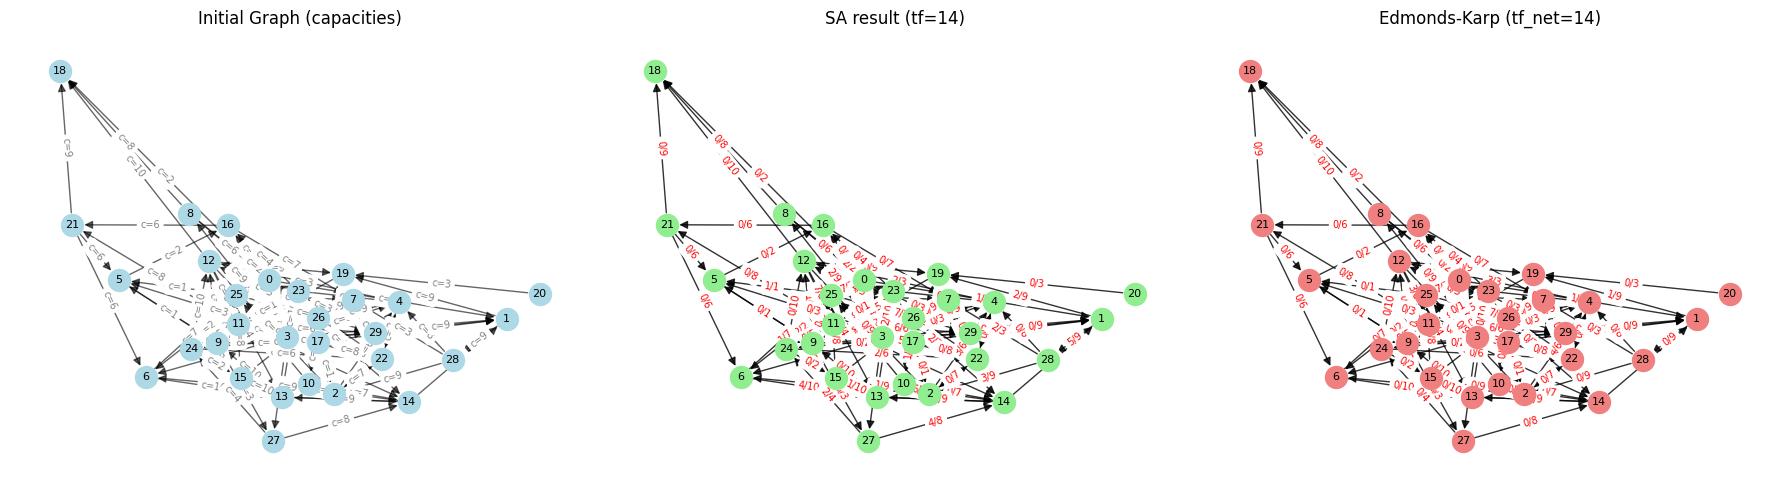

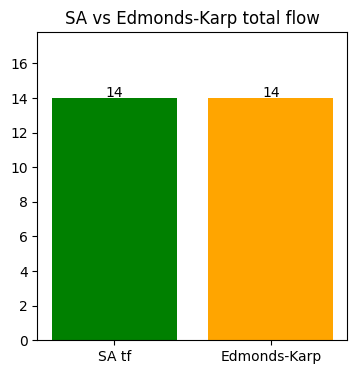


R2 report:
SA tf = 14
Edmonds-Karp tf_net = 14
SA reached the optimal flow value (tf ≈ tf_net).


In [7]:
G_orig = build_random_graph(num_nodes=GRAPH_NODE_COUNT, p=CONNECTIVITY_P, cap_min=CAPACITY_MIN, cap_max=CAPACITY_MAX, seed=123)
print(f"Random graph: nodes={G_orig.number_of_nodes()}, edges={G_orig.number_of_edges()}")
pos_R2 = nx.spring_layout(G_orig, seed=123)
T_INIT_R2 = 200.0
ALPHA_R2 = 0.03
MAX_ITERS_PER_T_R2 = 200
PATH_CUTOFF_R2 = 9
MAX_PATH_CACHE_R2 = 800
path_cache_R2 = sample_simple_paths(G_orig, SOURCE_NODE, SINK_NODE, cutoff=PATH_CUTOFF_R2, max_paths=MAX_PATH_CACHE_R2)
t0 = time.time()
G_sa_res, best_score, hist_sa = simulated_annealing_fast(deepcopy(G_orig), SOURCE_NODE, SINK_NODE,
                                                        T_init=T_INIT_R2, alpha=ALPHA_R2, max_iters_per_T=MAX_ITERS_PER_T_R2,
                                                        path_cache=path_cache_R2, path_cutoff=PATH_CUTOFF_R2, max_path_cache=MAX_PATH_CACHE_R2,
                                                        seed=130, use_greedy_init=True)
t_sa = time.time() - t0
tf_sa = flow_into_sink(G_sa_res, SINK_NODE)
print(f"SA finished in {t_sa:.2f}s — tf (SA) = {tf_sa}")
t1 = time.time()
G_for_max = nx.DiGraph()
G_for_max.add_nodes_from(G_orig.nodes())
for u,v,d in G_orig.edges(data=True):
    G_for_max.add_edge(u, v, capacity=d['capacity'])
tf_net = nx.maximum_flow_value(G_for_max, SOURCE_NODE, SINK_NODE, flow_func=nx.algorithms.flow.edmonds_karp)
t_ek = time.time() - t1
print(f"Edmonds-Karp finished in {t_ek:.2f}s — tf_net (optimal) = {tf_net}")
flow_val, flow_dict = nx.maximum_flow(G_for_max, SOURCE_NODE, SINK_NODE, flow_func=nx.algorithms.flow.edmonds_karp)
G_ek = deepcopy(G_orig)
for u in flow_dict:
    for v, f in flow_dict[u].items():
        if G_ek.has_edge(u, v):
            G_ek[u][v]['flow'] = f
for u,v,d in G_ek.edges(data=True):
    if 'flow' not in d:
        d['flow'] = 0
for u,v,d in G_sa_res.edges(data=True):
    if 'flow' not in d:
        d['flow'] = 0
print("\nValidating SA solution (R2)...")
validate_solution(G_sa_res, source=SOURCE_NODE, sink=SINK_NODE)
print("Validating Edmonds-Karp solution (R2)...")
validate_solution(G_ek, source=SOURCE_NODE, sink=SINK_NODE)
fig, axs = plt.subplots(1,3, figsize=(18,5))
ax = axs[0]
nx.draw_networkx_nodes(G_orig, pos_R2, node_size=250, node_color='lightblue', ax=ax)
nx.draw_networkx_labels(G_orig, pos_R2, font_size=8, ax=ax)
nx.draw_networkx_edges(G_orig, pos_R2, ax=ax, alpha=0.6, arrowsize=12)
edge_labels_capacity = {(u,v): f"c={d['capacity']}" for u,v,d in G_orig.edges(data=True)}
nx.draw_networkx_edge_labels(G_orig, pos_R2, edge_labels=edge_labels_capacity, font_color='gray', font_size=7, ax=ax)
ax.set_title("Initial Graph (capacities)")
ax.axis('off')
ax = axs[1]
nx.draw_networkx_nodes(G_sa_res, pos_R2, node_size=250, node_color='lightgreen', ax=ax)
nx.draw_networkx_labels(G_sa_res, pos_R2, font_size=8, ax=ax)
nx.draw_networkx_edges(G_sa_res, pos_R2, ax=ax, alpha=0.8, arrowsize=12)
edge_labels_sa = {(u,v): f"{d['flow']}/{d['capacity']}" for u,v,d in G_sa_res.edges(data=True)}
nx.draw_networkx_edge_labels(G_sa_res, pos_R2, edge_labels=edge_labels_sa, font_color='red', font_size=7, ax=ax)
ax.set_title(f"SA result (tf={tf_sa})")
ax.axis('off')
ax = axs[2]
nx.draw_networkx_nodes(G_ek, pos_R2, node_size=250, node_color='lightcoral', ax=ax)
nx.draw_networkx_labels(G_ek, pos_R2, font_size=8, ax=ax)
nx.draw_networkx_edges(G_ek, pos_R2, ax=ax, alpha=0.8, arrowsize=12)
edge_labels_ek = {(u,v): f"{d['flow']}/{d['capacity']}" for u,v,d in G_ek.edges(data=True)}
nx.draw_networkx_edge_labels(G_ek, pos_R2, edge_labels=edge_labels_ek, font_color='red', font_size=7, ax=ax)
ax.set_title(f"Edmonds-Karp (tf_net={tf_net})")
ax.axis('off')
plt.tight_layout()
plt.show()
plt.figure(figsize=(4,4))
plt.bar(['SA tf','Edmonds-Karp'], [tf_sa, tf_net], color=['green','orange'])
plt.title("SA vs Edmonds-Karp total flow")
for i, val in enumerate([tf_sa, tf_net]):
    plt.text(i, val + 0.05, str(val), ha='center')
plt.ylim(0, max(tf_sa, tf_net)*1.2 + 1)
plt.show()
print("\nR2 report:")
print("SA tf =", tf_sa)
print("Edmonds-Karp tf_net =", tf_net)
if abs(tf_sa - tf_net) < 1e-6:
    print("SA reached the optimal flow value (tf ≈ tf_net).")
else:
    print("SA produced near-optimal flow (expected small difference due to randomness).")

**R3**

Running R3: 30 random graphs, N=30, p=0.1. This may take several minutes...
Validation for graph 0, T_init=100.0:
Validation: PASS (capacities and conservation satisfied).
Validation for graph 0, T_init=1000.0:
Validation: PASS (capacities and conservation satisfied).
Validation for graph 1, T_init=100.0:
Validation: PASS (capacities and conservation satisfied).
Validation for graph 1, T_init=1000.0:
Validation: PASS (capacities and conservation satisfied).
Validation for graph 2, T_init=100.0:
Validation: PASS (capacities and conservation satisfied).
Validation for graph 2, T_init=1000.0:
Validation: PASS (capacities and conservation satisfied).
Validation for graph 3, T_init=100.0:
Validation: PASS (capacities and conservation satisfied).
Validation for graph 3, T_init=1000.0:
Validation: PASS (capacities and conservation satisfied).
Validation for graph 4, T_init=100.0:
Validation: PASS (capacities and conservation satisfied).
Validation for graph 4, T_init=1000.0:
Validation: PASS 

/tmp/ipython-input-2275874863.py:70: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_box, labels=labels)


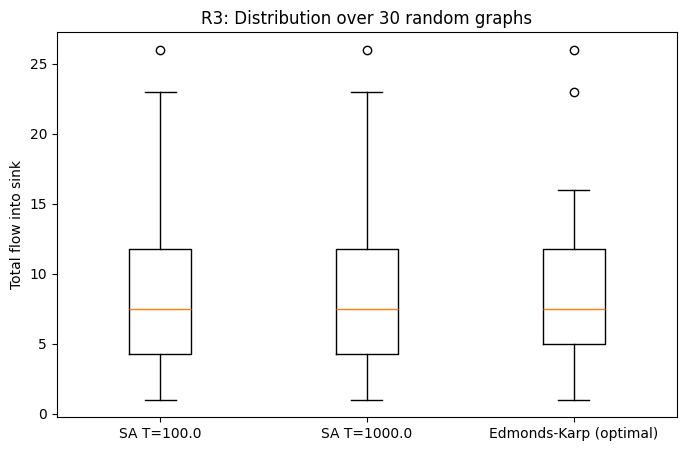

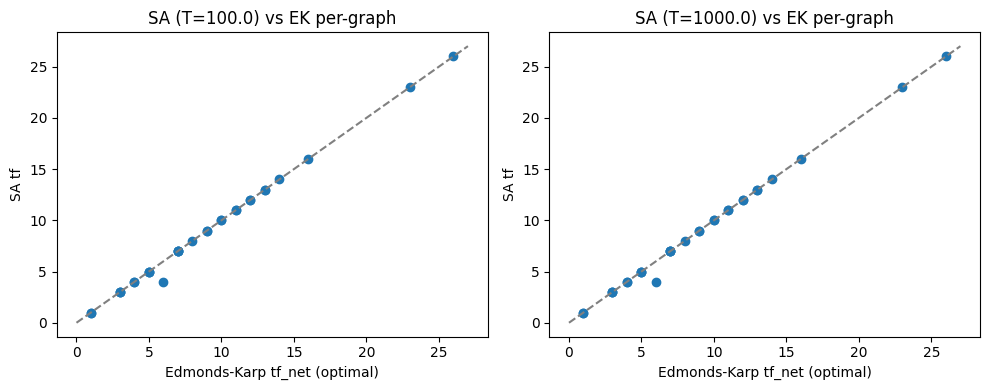

In [8]:
NUM_GRAPHS = 30
BASE_SEED = 1000
T_INITS = [100.0, 1000.0]
ALPHA_EXP = 0.03
MAX_ITERS_PER_T_EXP = 200
PATH_CUTOFF_EXP = 9
MAX_PATH_CACHE_EXP = 800
USE_GREEDY_INIT = False
results = {T: {'tf_sa': [], 'tf_net': [], 'time_sa': [], 'time_ek': []} for T in T_INITS}
print(f"Running R3: {NUM_GRAPHS} random graphs, N={GRAPH_NODE_COUNT}, p={CONNECTIVITY_P}. This may take several minutes...")
for i in range(NUM_GRAPHS):
    seed_i = BASE_SEED + i
    G = build_random_graph(num_nodes=GRAPH_NODE_COUNT, p=CONNECTIVITY_P, cap_min=CAPACITY_MIN, cap_max=CAPACITY_MAX, seed=seed_i)
    if not nx.has_path(G, SOURCE_NODE, SINK_NODE):
        trial = 0
        while not nx.has_path(G, SOURCE_NODE, SINK_NODE) and trial < 10:
            G = build_random_graph(num_nodes=GRAPH_NODE_COUNT, p=CONNECTIVITY_P, cap_min=CAPACITY_MIN, cap_max=CAPACITY_MAX, seed=seed_i + 100 + trial)
            trial += 1
    G_cap = nx.DiGraph()
    G_cap.add_nodes_from(G.nodes())
    for u,v,d in G.edges(data=True):
        G_cap.add_edge(u, v, capacity=d['capacity'])
    t0_ek = time.time()
    tf_net = nx.maximum_flow_value(G_cap, SOURCE_NODE, SINK_NODE, flow_func=nx.algorithms.flow.edmonds_karp)
    t_ek = time.time() - t0_ek
    path_cache = sample_simple_paths(G, SOURCE_NODE, SINK_NODE, cutoff=PATH_CUTOFF_EXP, max_paths=MAX_PATH_CACHE_EXP)
    if not path_cache:
        print(f"Graph {i}: no paths found from {SOURCE_NODE} to {SINK_NODE}; skipping.")
        continue
    for T_init in T_INITS:
        G_for_sa = deepcopy(G)
        t0 = time.time()
        G_sa_res, best_score, hist = simulated_annealing_fast(
            G_for_sa, SOURCE_NODE, SINK_NODE,
            T_init=T_init, alpha=ALPHA_EXP, max_iters_per_T=MAX_ITERS_PER_T_EXP,
            path_cache=path_cache, path_cutoff=PATH_CUTOFF_EXP, max_path_cache=MAX_PATH_CACHE_EXP,
            seed=seed_i + int(T_init), use_greedy_init=USE_GREEDY_INIT
        )
        t_sa = time.time() - t0
        tf_sa = flow_into_sink(G_sa_res, SINK_NODE)
        results[T_init]['tf_sa'].append(tf_sa)
        results[T_init]['tf_net'].append(tf_net)
        results[T_init]['time_sa'].append(t_sa)
        results[T_init]['time_ek'].append(t_ek)
        print(f"Validation for graph {i}, T_init={T_init}:")
        validate_solution(G_sa_res, source=SOURCE_NODE, sink=SINK_NODE)
    if (i+1) % 5 == 0 or i == NUM_GRAPHS-1:
        print(f"Completed {i+1}/{NUM_GRAPHS} graphs.")
for T_init in T_INITS:
    tf_salist = results[T_init]['tf_sa']
    tf_net_list = results[T_init]['tf_net']
    mean_sa = statistics.mean(tf_salist) if tf_salist else 0.0
    std_sa = statistics.stdev(tf_salist) if len(tf_salist) > 1 else 0.0
    mean_net = statistics.mean(tf_net_list) if tf_net_list else 0.0
    std_net = statistics.stdev(tf_net_list) if len(tf_net_list) > 1 else 0.0
    diffs = [net - sa for sa, net in zip(tf_salist, tf_net_list)]
    mean_diff = statistics.mean(diffs) if diffs else 0.0
    sd_diff = statistics.stdev(diffs) if len(diffs) > 1 else 0.0
    pct_of_opt = [100.0 * sa/net if net>0 else 100.0 for sa,net in zip(tf_salist, tf_net_list)]
    mean_pct = statistics.mean(pct_of_opt) if pct_of_opt else 0.0
    std_pct = statistics.stdev(pct_of_opt) if len(pct_of_opt) > 1 else 0.0
    print("\n--- Summary for T_init =", T_init, "---")
    print(f"SA: mean tf = {mean_sa:.3f}, std = {std_sa:.3f}")
    print(f"EK: mean tf_net = {mean_net:.3f}, std = {std_net:.3f}")
    print(f"Mean (tf_net - tf_sa) = {mean_diff:.3f} (sd {sd_diff:.3f})")
    print(f"SA average percent of optimal = {mean_pct:.2f}% (std {std_pct:.2f}%)")
plt.figure(figsize=(8,5))
data_box = [results[T_INITS[0]]['tf_sa'], results[T_INITS[1]]['tf_sa'], results[T_INITS[0]]['tf_net']]
labels = [f"SA T={T_INITS[0]}", f"SA T={T_INITS[1]}", "Edmonds-Karp (optimal)"]
plt.boxplot(data_box, labels=labels)
plt.ylabel("Total flow into sink")
plt.title(f"R3: Distribution over {NUM_GRAPHS} random graphs")
plt.show()
plt.figure(figsize=(10,4))
for idx, T_init in enumerate(T_INITS):
    plt.subplot(1,2,idx+1)
    plt.scatter(results[T_init]['tf_net'], results[T_init]['tf_sa'])
    if results[T_init]['tf_net'] and results[T_init]['tf_sa']:
        maxv = max(max(results[T_init]['tf_net']), max(results[T_init]['tf_sa'])) + 1
    else:
        maxv = 1
    plt.plot([0,maxv],[0,maxv], '--', color='gray')
    plt.xlabel("Edmonds-Karp tf_net (optimal)")
    plt.ylabel("SA tf")
    plt.title(f"SA (T={T_init}) vs EK per-graph")
plt.tight_layout()
plt.show()

Raising the initial temperature from 100 to 1000 did not noticeably change the average flow. This suggests the algorithm’s neighborhood moves and cooling schedule already provide enough exploration for these graph instances, so making the start temperature larger doesn’t help much — the search can reach good solutions even with T = 100